# Sentence Reconstruction
## Christian Di Buò 0001128790

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. I restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [1]:
!pip install datasets

Download the dataset

In [2]:
!pip install tensorflow

In [3]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

2024-06-12 07:40:48.058785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 07:40:48.720437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Filter row with length greater than 8.


In [4]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Create a tokenizer and Detokenizer

In [5]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

2024-06-12 07:41:16.819219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


Remove from corpus the sentences where any unknow word appears

In [6]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [7]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [8]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, mode="training", batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.mode = mode
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
            np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])
        
        if self.mode=="training" or self.mode=="validation":
            # teacher forcing
            target = np.array([np.append(sentence[1:], 0) for sentence in result])
            data_batch_mask = np.where(data_batch==0,0,1)
            result_mask = np.where(result==0,0,1)
            return (data_batch , result, data_batch_mask, result_mask), target
        
        elif self.mode=="test":
            return data_batch, result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [9]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [36]:
train_generator = DataGenerator(shuffled_data[:217000], batch_size=500)
val_generator = DataGenerator(shuffled_data[217000:220000], batch_size=1000, mode='test')

In [37]:
'''x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")
'''

'x, y = test_generator.__getitem__(1)\nx = detokenizer(x)\ny = detokenizer(y)\n\nfor i in range(7):\n  print("original: ", y[i])\n  print("shuffled: ", x[i])\n  print("\n")\n'

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [38]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [39]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

In [40]:
!pip install keras_nlp
!pip install keras

In [41]:
import tensorflow as tf
import keras_nlp
import keras
import numpy as np
from keras.callbacks import EarlyStopping

### Instatiating the model

The model is instantiated with the following parameters.

Each of them was chosen through trial and error, by training different models with different combinations of parameters. 

Some of the most influential were the number of heads and the dropout rate.
- The number of heads influences how the model captures the underlying dependencies in sequences. 
- The droupout rate influences how much the model is subject to overfitting and underfitting. 

In [42]:
epochs = 200
max_sequence_length = 28
vocab_size = 10000
num_layers = 8
embed_dim = 128
intermediate_dim = 512
num_heads = 15
dropout = 0.1

# Transformer

This is the transformer architecture i have used. 

I have also added an additonal final Dense layer, which converts the resulting vector at each location into output token probabilities.
Some noteworthy implementation details:
- I have implemented a custom learning rate the CosineDecayRestarts(): By adopting the restart technique the model was able to escape plateaus, leading to a noticeable enhancement in overall performance
- I have used the Validation CallBack, which was instrumental in significantly improving the model's score. This custom callback monitors the model's performance during training by evaluating its predictions on the validation set.

In [43]:
def get_transformer():
    padding_mask_enc = keras.Input( shape=(None,), name="padding_mask_enc",)
    padding_mask_dec = keras.Input( shape=(None,),name="padding_mask_dec",)
    
    encoder_inputs = keras.Input(shape=(None,), name="encoder_inputs")
    embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    x = embedding(encoder_inputs)
    for i in range(num_layers-1):
        x = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=num_heads,dropout=dropout)(inputs=x, padding_mask=padding_mask_enc)
    encoder_outputs = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=num_heads,dropout=dropout)(inputs=x, padding_mask=padding_mask_enc)



    # Decoder
    decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")

    decoder_embedding = embedding(decoder_inputs)
    x = keras_nlp.layers.PositionEmbedding(sequence_length=max_sequence_length)(decoder_embedding)
    x += decoder_embedding
    for i in range(num_layers):
        x = keras_nlp.layers.TransformerDecoder(intermediate_dim=intermediate_dim, num_heads=num_heads,dropout=dropout)(decoder_sequence=x, encoder_sequence=encoder_outputs, decoder_padding_mask=padding_mask_dec, encoder_padding_mask=padding_mask_enc)
    decoder_outputs = keras.layers.Dense(vocab_size, activity_regularizer = 'l2', activation="softmax")(x)
    transformer = keras.Model([encoder_inputs, decoder_inputs, padding_mask_enc, padding_mask_dec], decoder_outputs, name="transformer",)
    return transformer

In [44]:
transformer = get_transformer()

# Training the model

---

The model uses an Adam optimizer. The learning rate schedule was chosen according to the paper "Attention is all you need" in which Transformers where first introduced. 

In [45]:
class MyLRSchedule(keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
restart_scheduler = keras.optimizers.schedules.CosineDecayRestarts(8e-04,3e04,t_mul=0.5,m_mul=0.01)

### Loss function and metrics
The sparse categorical cross-entropy and accuracy are extended to include a padding mask.


In [46]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [47]:
def clean_sentence(x):
    x = x.replace('<start>', '').replace('<end>', '').replace('<pad>', '').strip()
    return x

## Translator module

This module is responsible for wrapping the computation of the transformer. 
In essence, it generates a bag of words from a batch of shuffled sentences, and gradually computes the index of the best word prediction given by the transformer.  


In [48]:
class Translator(tf.Module):
    def __init__(self, transformer, tokenizer):
        self.transformer = transformer
        self.tokenizer = tokenizer

    def __call__(self, sentences, max_length=28):
        batch_size = sentences.shape[0]

        # generate word list for each sentence
        bow = [[word for word in sentence if word not in [3, 2, 0]] for sentence in sentences]
        # starting vector for prediction, it contains the sos index
        output = [[3] for _ in range(batch_size)]

        # during inference, output will be filled with the final sentence.

        for i in range(1, max_length):

            predictions = np.array(self.transformer((np.array(sentences), np.array(output), np.where(np.array(sentences)==0,0,1),np.where(np.array(output)==0,0,1)), training=False))
            # remove useless dimensions
            predictions = predictions[:, -1, :]
            for j in range(batch_size):
                if len(bow[j]) == 0:
                    # no more words to use
                    cand_token = 2
                else:
                    # choose index with highest score
                    s_prediction = predictions[j, np.array(bow[j])]
                    cand_index = np.argmax(s_prediction)
                    cand_token = bow[j][cand_index]
                    del bow[j][cand_index]

                output[j].append(cand_token)
        return output

## Validation Callback

In [49]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import numpy as np

class ValidationCallback(Callback):
    def __init__(self, tokenizer,generator, batch_size, max_patience):
        super(ValidationCallback, self).__init__()
        self.tokenizer = tokenizer
        self.generator = generator
        self.batch_size = batch_size
        self.max_patience = max_patience
        self.patience = 0
        self.max_score = 0
        
    def on_epoch_end(self, epoch, logs=None):
        score_batch_size = self.batch_size
        total_val_size = 3000
        tot_score = 0
        self.model.save_weights('current_model.weights.h5')
        model = get_transformer()
        model.load_weights('current_model.weights.h5')
        translator = Translator(model, self.tokenizer)
        for i in range(total_val_size // score_batch_size):
            shuffled, ordered = self.generator[i]
            y_pred = translator(shuffled)
            pred_sentences = detokenizer(y_pred)
            original_sentences = detokenizer(ordered)
            b_score = 0
            for j in range(score_batch_size):
                b_score += score(clean_sentence(original_sentences[j]), clean_sentence(pred_sentences[j]))
                
            tot_score += b_score
            print(f"\nValidation Score after batch {i+1}: {tot_score / ((i+1) * score_batch_size)}")
        final_score = tot_score / total_val_size
        if final_score >= self.max_score:
            self.patience = 0
            self.max_score = final_score
            self.model.save_weights('best_model.weights.h5')
        else:
            if self.patience == self.max_patience:
                self.model.load_weights('best_model.weights.h5')
                self.model.stop_training = True
            else:
                self.patience +=1
        logs['val_score'] = final_score

In [50]:
score_callback = ValidationCallback(tokenizer=tokenizer,generator=val_generator,batch_size=1000, max_patience=9)

### Compiling and training the model

The model is built and set up for training. 

In [51]:
transformer.summary()
opt = keras.optimizers.Adam(learning_rate=restart_scheduler,beta_1=0.9, beta_2=0.98,epsilon=1e-09, use_ema=True)
transformer.compile(optimizer=opt, loss=masked_loss, metrics=[masked_accuracy])

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 128) │  1,280,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask_enc    │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    194,152 │ embedding_2[0][0… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    194,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    194,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    194,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    194,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    194,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, None, 128) │      3,584 │ embedding_2[1][0] │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    194,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 128) │          0 │ position_embeddi… │
│                     │                   │            │ embedding_2[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask_dec    │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    194,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    256,336 │ add_2[0][0],      │
│ (TransformerDecode… │                   │            │ padding_mask_dec… │
│                     │                   │            │ padding_mask_enc… │
│                     │                   │            │ transformer_enco

 Total params: 6,177,488 (23.57 MB)

 Trainable params: 6,177,488 (23.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718178258.088674   19988 service.cc:145] XLA service 0x3cb2aae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718178258.088789   19988 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-06-12 07:44:19.546791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1718178261.480448   19988 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentro

434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 6.6173 - masked_accuracy: 0.2270

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1000, 15, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Validation Score after batch 1: 0.3226998393399415

Validation Score after batch 2: 0.3191436294918251

Validation Score after batch 3: 0.31954940604672083
434/434 ━━━━━━━━━━━━━━━━━━━━ 271s 249ms/step - loss: 6.6154 - masked_accuracy: 0.2272 - val_score: 0.3195
Epoch 2/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 4.5017 - masked_accuracy: 0.5545
Validation Score after batch 1: 0.3877189133384854

Validation Score after batch 2: 0.38792770578149316

Validation Score after batch 3: 0.38820067748069503
434/434 ━━━━━━━━━━━━━━━━━━━━ 108s 249ms/step - loss: 4.5013 - masked_accuracy: 0.5546 - val_score: 0.3882
Epoch 3/200
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 3.9274 - masked_accuracy: 0.6757
Validation Score after batch 1: 0.417299891249059

Validation Score after batch 2: 0.40897562529922005

Validation Score after batch 3: 0.4108804835110544
434/434 ━━━━━━━━━━━━━━━━━━━━ 108s 249ms/step - loss: 3.9273 - masked_accuracy: 0.6757 - val_score: 0.4109
Epoch 4/200
434/434 ━

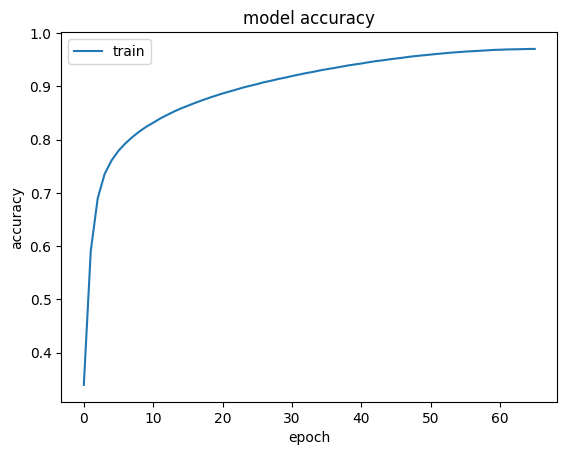

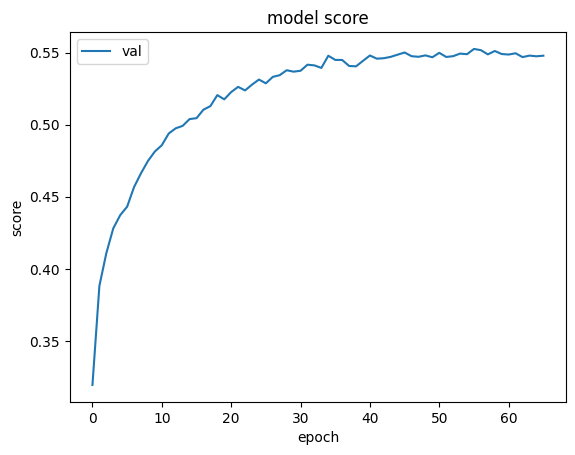

In [52]:
import matplotlib.pyplot as plt

history = transformer.fit(train_generator,epochs=epochs,callbacks=score_callback)
#  "Accuracy"
plt.plot(history.history['masked_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['val_score'])
plt.title('model score')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['val'], loc='upper left')
plt.show()


## Computing the score

Here i have tested the translator and computed the score. 

To do that, I have computed a score on 3K generated samples.

Since computing the score directly on 3K batches could give us some problems in Colab, it is computed on batches of 500 samples each.

Then, the total score computed as the average between batches.  

In [43]:
#transformer.load_weights('best_model.weights.h5')

In [53]:
score_batch_size = 500
total_test_size = 3000
score_ = 0
translator=Translator(transformer,tokenizer)
test_generator = DataGenerator(shuffled_data[220000:], mode='test', batch_size=score_batch_size)
for i in range(total_test_size//score_batch_size):
    shuffled, ordered = test_generator[i]
    y_pred = translator(shuffled)
    b_score = 0                   # score associated with each batch

    pred_sentences = detokenizer(y_pred)
    original_sentences = detokenizer(ordered)

    for j in range(score_batch_size) :
        b_score += score(clean_sentence(original_sentences[j]), clean_sentence(pred_sentences[j]))

    score_ += b_score
    print("\n====BATCH OVER====")
    print("Score as of batch ", i, ": ", score_/((i+1)*score_batch_size))

score_ = score_/total_test_size
print("\n====ALL OVER====")
print("Final score: ", score_)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (500, 15, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



====BATCH OVER====
Score as of batch  0 :  0.5386423473376262

====BATCH OVER====
Score as of batch  1 :  0.5505469472928517

====BATCH OVER====
Score as of batch  2 :  0.550114246214616

====BATCH OVER====
Score as of batch  3 :  0.5505469864357261

====BATCH OVER====
Score as of batch  4 :  0.5457898397512274

====BATCH OVER====
Score as of batch  5 :  0.5434817910222219

====ALL OVER====
Final score:  0.5434817910222219


# Conclusion

My final score is: 

After conducting numerous experiments and iterations, I have developed a final model, which uses the transformer architecture proposed in the paper Attention Is All You Need. I have also tried different architectures such as LSTM but the performances were definetly worse.

I have not used data augmentation since it does not give any apport to the score of the model, it just increase the training time

Additionally, I have further improved the model's performance by adding the Validation CallBack, useful to see the performance of the model directly on the validation score; this has allowed the model to arrive at an higher accuracy and perform better on the test. Furthermore, I have choosen the CosineDecay as learning rate, I have used it to personalize the learning rate and to go beyond the Plateau encountered. 

The model obtains average performance.

An important implementation detail:
- > I have done all the tests trying to optimizer a models with a lower number of parameters than the maximum imposed by the constraint, this was done in order to achive the 2 bonus points (i have used only 6M w.r.t the 20M imposed). Running the same model with 20M parameters led to a significantly increase in the test score: around 0.573.


For completeness I would like to say that I was inspired by the following papers:

* https://aclanthology.org/2021.naacl-main.134.pdf
* https://arxiv.org/pdf/1706.03762.pdf
* https://jcheminf.biomedcentral.com/articles/10.1186/s13321-023-00700-4
